In [1]:
import nibabel as nib
import hcp_utils as hcp
import nilearn
import pandas as pd
import numpy as np
from glob import glob
import os
from subprocess import call
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import surfdist.analysis

Matplotlib created a temporary config/cache directory at /tmp/pbs.5341961.pbsha.ib.sockeye/matplotlib-r4wwjwih because the default path (/home/jeilbott/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/jeilbott/.conda/envs/conda/lib/python3.9/site-packages/surfdist/utils.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=True)
/home/jeilbott/.conda/envs/conda/lib/python3.9/site-packages/surfdist/utils.py:30: Numba

In [2]:
# define custom functions
def write_dscalar(data, filename, label=['data']):
    cortL = np.arange(hcp.struct.cortex_left.start,hcp.struct.cortex_left.stop)
    cortL[:] = 1
    cortL = hcp.left_cortex_data(cortL)
    cortR = np.arange(hcp.struct.cortex_right.start,hcp.struct.cortex_right.stop)-hcp.struct.cortex_right.start
    cortR[:] = 1
    cortR = hcp.right_cortex_data(cortR)
    scalar_axis = nib.cifti2.ScalarAxis(label)
    brain_model = nib.cifti2.BrainModelAxis.from_mask(cortL, 'CortexLeft')
    brain_model = brain_model + nib.cifti2.BrainModelAxis.from_mask(cortR, 'CortexRight')
    cifti = nib.Cifti2Image(data, header=nib.Cifti2Header.from_axes((scalar_axis, brain_model)))
    cifti.to_filename(filename)
    
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

def cropCifti(cifti, condition):
    vol_path = '/arc/project/st-tv01-1/hcp/code/hallee_hcp_targets/data'
    # get volumes
    if condition == 'MOVIE2' or condition == 'REST1':
        vols = np.loadtxt(f'{vol_path}/movie2_vols.csv') == 0
    elif condition == 'MOVIE4' or condition == 'REST4':
        vols = np.loadtxt(f'{vol_path}/movie4_vols.csv') == 0
    cifti = nib.load(cifti).get_fdata()
    # crop 
    if len(vols) > cifti.shape[0]:
        vols = vols[:cifti.shape[0]]
    elif cifti.shape[0] > len(vols):
        cifti = cifti[:len(vols),:]
    return cifti[vols,:] # rm volumes

In [3]:
# setup data/paths
condition = ['MOVIE2', 'MOVIE4', 'REST1', 'REST4']
hcp_path = '/arc/project/st-tv01-1/hcp'
data_path = os.path.join(hcp_path, 'data-clean')
out_path = '/scratch/st-tv01-1/hcp/targets/dual_reg'
indiv_out = os.path.join(out_path, 'indiv')
sub = np.loadtxt(os.path.join(hcp_path,'targets','m2m4_sub_n109.csv'), dtype=str)
if not os.path.isdir(out_path):
    os.makedirs(out_path)

In [23]:
# compute group average seed map for each condition
sg_mask = hcp.mmp.map_all[hcp.struct.cortex] == 164
group_seedmap = np.zeros((len(condition),len(sg_mask)))
group_seedmap2 = np.zeros((len(condition),len(sg_mask)))
for i,c in enumerate(condition):
    group = np.zeros((0, hcp.struct.cortex.stop))
    n = np.zeros(group.shape[1])
    for s in sub:
        nii = glob(os.path.join(data_path, s + '*','*'+c+'*.nii'))
        if len(nii) == 1:
            cifti = cropCifti(nii[0], c)[:,hcp.struct.cortex]
            if group.shape[0] == 0:
                group = np.zeros((cifti.shape[0], group.shape[1]))
            mask = ~np.isnan(cifti.mean(axis=0))
            group[:, mask] = group[:, mask] + cifti[:, mask]
            n[mask] = n[mask] + 1
            sg_tc_indiv = cifti[:,sg_mask].mean(axis=1).reshape((1,-1))
            group_seedmap2[i,mask] = group_seedmap2[i,mask] + np.arctanh(corr2_coeff(cifti[:,mask].T, sg_tc_indiv))[:,0]
        else:
            print(f'ERROR:\t{s} {c} not found')
    # group average cifti
    group = np.divide(group, n)
    # seed map
    sg_tc = group[:,sg_mask].mean(axis=1).reshape((1,-1))
    group_seedmap[i,:] = np.arctanh(corr2_coeff(group.T, sg_tc))[:,0]
    group_seedmap2[i,:] = np.divide(group_seedmap2[i,:], n)
# write all seedmaps to a cifti
write_dscalar(group_seedmap, f'{out_path}/group_seedmap_n{len(sub)}.dscalar.nii', label=condition)
write_dscalar(group_seedmap2, f'{out_path}/group_seedmap2_n{len(sub)}.dscalar.nii', label=condition)
    

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

In [24]:
# load group seedmap and dlpfc mask
group_seedmap = nib.load(f'{out_path}/group_seedmap2_n{len(sub)}.dscalar.nii').get_fdata()[:,hcp.struct.cortex]
dlpfc = '/arc/project/st-tv01-1/hcp/code/hallee_hcp_targets/data/dlpfc.dscalar.nii'
dlpfc_mask = nib.load(dlpfc).get_fdata()[:,hcp.struct.cortex].squeeze() != 0
group_seedmap[:, dlpfc_mask] = 0
# compute individual seed maps for each condition
indiv_out = os.path.join(out_path, 'indiv')
if not os.path.isdir(indiv_out):
    os.makedirs(indiv_out)
for i,c in enumerate(condition):
    group = np.zeros((0, hcp.struct.cortex.stop))
    n = np.zeros(group.shape[1])
    for s in sub:
        nii = glob(os.path.join(data_path, s + '*','*'+c+'*.nii'))
        if len(nii) == 1:
            # load cifti and z-score
            cifti =cropCifti(nii[0], c)[:,hcp.struct.cortex]
            mask = ~np.isnan(cifti.mean(axis=0))
            cifti = stats.zscore(cifti, axis=0)
            # spatial regression to get seed tc
            seed_tc = np.matmul(cifti, group_seedmap[i,:]).reshape((1,-1))
            indiv_seedmap = np.zeros((1,cifti.shape[1]))
            indiv_seedmap[:] = np.nan
            indiv_seedmap[:,mask] = corr2_coeff(cifti.T, seed_tc)[mask,0]
            # seed map
            write_dscalar(indiv_seedmap, f'{indiv_out}/{c}_{s}_seedmap.dscalar.nii')
        else:
            print(f'ERROR:\t{s} {c} not found')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

/home/jeilbott/.conda/envs/conda/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


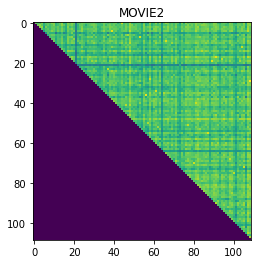

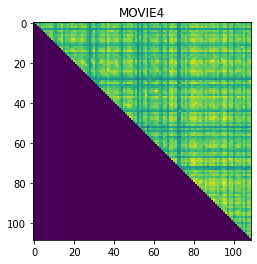

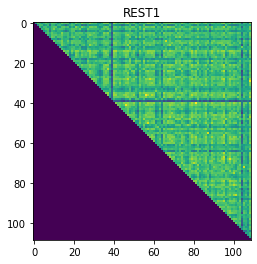

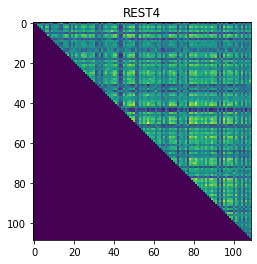

In [4]:
# inter sub correlation
inter = dict()

for i,c in enumerate(condition):
    group = np.zeros((0, hcp.struct.cortex.stop))
    inter[c] = np.zeros((len(sub),len(sub)))
    for i1,s1 in enumerate(sub):
        data1 = nib.load(f'{indiv_out}/{c}_{s1}_seedmap.dscalar.nii').get_fdata()[:,hcp.struct.cortex]
        for i2,s2 in enumerate(sub):
            if i1<i2:
                data2 = nib.load(f'{indiv_out}/{c}_{s2}_seedmap.dscalar.nii').get_fdata()[:,hcp.struct.cortex]
                inter[c][i1,i2] = stats.pearsonr(data1.squeeze(),data2.squeeze())[0]
    #plt.figure()
    #plt.title(c)
    #plt.imshow(inter[c])
    #plt.savefig(os.path.join(out_path,f'{c}_groupcorr.png'), format='png')

# make inter df
df = pd.DataFrame(columns=['inter_'+x for x in condition])
for i,s in enumerate(sub):
    for c in condition:
        df.loc[s, 'inter_'+c] = np.sum(inter[c][:,i]+inter[c][i,:])/(len(sub)-1)
df.to_csv(f'inter_seedmap_n{len(sub)}.csv')


In [ ]:
# intra sub ICC
intra = pd.DataFrame(columns=['intra_ICC'])
for i,s in enumerate(sub):
    df = pd.DataFrame(columns = ['subject', 'condition', 'value', 'edge'])
    for j,c in enumerate(condition):
        data = nib.load(f'{indiv_out}/{c}_{s}_seedmap.dscalar.nii').get_fdata()[:,hcp.struct.cortex].transpose()
        n = data.shape[0]
        edge = np.transpose(np.array(range(0, n), ndmin = 2))
        subject = np.full((n,1), s)
        cond = np.full((n,1), c)
        df_to_add = pd.DataFrame(np.concatenate((subject, cond, data, edge), axis = 1), columns = ['subject', 'condition', 'value', 'edge'])
        df = pd.concat([df, df_to_add])
    icc = pg.intraclass_corr(data=df,targets='edge',raters='condition',ratings='value')
    #print(s)
    intra.loc[s, 'intra_ICC'] = icc.loc[1,'ICC']
# write csv
intra.to_csv(f'intra_seedmap_n{len(sub)}.csv')

104416


In [105]:
# get dlpfc vertex numbers 
dlpfc = '/arc/project/st-tv01-1/hcp/code/hallee_hcp_targets/data/dlpfc.dscalar.nii'
dlpfc_mask = nib.load(dlpfc).get_fdata()[:,hcp.struct.cortex_left]
cortL = nib.load('/arc/project/st-tv01-1/hcp/code/hallee_hcp_targets/data/hcp.tmp.lh.dscalar.nii').get_fdata()
cortL = np.array(np.where(cortL != 0)[1], dtype=np.int32)
dlpfc_vert = cortL[dlpfc_mask[0,:]==1]
np.savetxt(f'{out_path}/dlpfc_verts.txt', dlpfc_vert, fmt='%d')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [131]:
# load dlpfc distances from each wb_command -surface-geodesic-distance map
dist = np.zeros((len(dlpfc_vert), len(dlpfc_vert)))
for i,v in enumerate(dlpfc_vert):
    tmp = nib.load(f'/scratch/st-tv01-1/hcp/targets/dual_reg/dlpfc_dist/dlpfc_{i+1}_vert{v}.shape.gii').agg_data()
    dist[i,:] = tmp[dlpfc_vert]
np.save(f'{out_path}/dlpfc_geodesic.npy',dist)

In [ ]:
# calculate thresholds for clustering
lh = '/arc/project/st-tv01-1/atlas/HCP_S1200/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii'
rh = '/arc/project/st-tv01-1/atlas/HCP_S1200/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii'
dlpfc = '/arc/project/st-tv01-1/hcp/code/hallee_hcp_targets/data/dlpfc.dscalar.nii'
dlpfc_mask = nib.load(dlpfc).get_fdata()[:,hcp.struct.cortex].squeeze() != 0
thresh = pd.DataFrame(columns=['condition', 'threshold'])

# create cluster output
thresh_prop = 0.005
for i,s in enumerate(sub):
    for j,c in enumerate(condition):
        cifti = f'{indiv_out}/{c}_{s}_seedmap.dscalar.nii'
        cifti_out = f'{indiv_out}/{c}_{s}_seedmap-cluster.dscalar.nii'
        data = nib.load(cifti).get_fdata()[:,hcp.struct.cortex]
        thresh_dlpfc = np.quantile(data[:,dlpfc_mask], thresh_prop)
        print(f'{s} {c} {thresh_dlpfc})
        os.system(f'wb_command -cifti-find-clusters {cifti} {thresh_dlpfc} 0 0 0 COLUMN {cifti_out} -less-than -left-surface {lh} -right-surface {rh} -cifti-roi {dlpfc}')

In [92]:
# get dlpfc cluster centers and info
thresh_prop = 0.005 # for naming only

dlpfc_dist = np.load(f'{out_path}/dlpfc_geodesic.npy')
dlpfc_nii = '/arc/project/st-tv01-1/hcp/code/hallee_hcp_targets/data/dlpfc.dscalar.nii'
dlpfc_mask = nib.load(dlpfc_nii).get_fdata()[:,hcp.struct.cortex_left].squeeze()
dlpfc_vert = np.loadtxt(f'{out_path}/dlpfc_verts.txt')
df = pd.DataFrame(columns=['sub', 'condition', 'cluster_size','centroid_vertex','centroid_dlpfc_index', 'centroid_value'])
row = 0
for i,s in enumerate(sub):
    for j,c in enumerate(condition):
        seed_data = nib.load(f'{indiv_out}/{c}_{s}_seedmap.dscalar.nii').get_fdata()[:,hcp.struct.cortex_left].squeeze()
        clust_data = nib.load(f'{indiv_out}/{c}_{s}_seedmap-cluster.dscalar.nii').get_fdata()[:,hcp.struct.cortex_left].squeeze()
        # restrict to dlpfc
        clust_data = clust_data[dlpfc_mask != 0]
        seed_data = seed_data[dlpfc_mask != 0]
        # get cluster sizes
        clust_num = np.unique(clust_data)
        clust_num = clust_num[clust_num!=0]
        clust_size = np.zeros(clust_num.shape)
        for k,n in enumerate(np.unique(clust_num)):
            if n != 0:
                clust_size[k] = sum(clust_data == n)
        # find largest clust
        clust_num_largest = clust_num[clust_size.argmax()]
        clust_mask = clust_data == clust_num_largest
        # find centroid
        clust_dist = dlpfc_dist[clust_mask, :]
        clust_dist = clust_dist[:, clust_mask].sum(axis=0)
        cent_idx = np.where(clust_mask)[0][clust_dist.argmin()]
        cent_vert = dlpfc_vert[cent_idx]
        cent_val = seed_data[cent_idx]
        df.loc[row,:] = [s, c, clust_size.max(), cent_vert, cent_idx, cent_val]
        row = row + 1
    
# write centers and info
df.to_csv(f'{out_path}/seedmap_dlpfc_centroids_thresh{thresh_prop}_n{len(sub)}.csv', index=False)


In [156]:
# get distances between condition centroids per subject
thresh_prop = 0.005 # for naming only

df = pd.read_csv(f'{out_path}/seedmap_dlpfc_centroids_thresh{thresh_prop}_n{len(sub)}.csv')
df_out = pd.DataFrame(columns=['sub', 'condition_pair', 'centroid_distance'])
dlpfc_dist = np.load(f'{out_path}/dlpfc_geodesic.npy')
for i,s in enumerate(sub):
    cond_idx = df.loc[df['sub'] ==int(s),['condition', 'centroid_dlpfc_index']].set_index('condition')
    cond_idx = cond_idx.loc[condition,'centroid_dlpfc_index'].tolist()
    cond_dist = dlpfc_dist[cond_idx, :]
    cond_dist = cond_dist[:, cond_idx]
    for j1,c1 in enumerate(condition):
        for j2,c2 in enumerate(condition):
            if j1<j2:
                df_out.loc[len(df_out.index)+1,:] = [s, f'{c1}_{c2}', cond_dist[j1,j2]]
df_out = df_out.pivot(index='sub', columns='condition_pair')          
df_out.to_csv(f'{out_path}/intrasub_centroid_distances_thresh{thresh_prop}_n{len(sub)}.csv')

In [157]:
stats.ttest_rel(df_out[:,'MOVIE2_MOVIE4'],df_out[:,'REST1_REST4'])

InvalidIndexError: (slice(None, None, None), 'MOVIE2_MOVIE4')

In [159]:
df_out[:,[]'centroid_distance','MOVIE2_MOVIE4')]

InvalidIndexError: (slice(None, None, None), ('centroid_distance', 'MOVIE2_MOVIE4'))